<a href="https://colab.research.google.com/github/kamilafariasg/exponential-smoothing-times-series/blob/main/exponential_smoothing_times_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análise temporal do preço de casas em Londres através de Exponential Smoothing**

Os dados vão do ano de 1995 a 2020 e foram obtidos no Kaggle. 

### **Importando Bibliotecas**

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
%matplotlib inline 
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **Preparando Drive para Ler Base de Dados**

In [3]:
#montando conexão com o Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#lendo base de dados
df = pd.read_csv("/content/drive/My Drive/dataset/housing_in_london_monthly_variables.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13549 entries, 0 to 13548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           13549 non-null  object 
 1   area           13549 non-null  object 
 2   average_price  13549 non-null  int64  
 3   code           13549 non-null  object 
 4   houses_sold    13455 non-null  float64
 5   no_of_crimes   7439 non-null   float64
 6   borough_flag   13549 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 741.1+ KB


### **Análise de Dados**

Tamanho da base. Contém 13549 linhas e 7 colunas.

In [5]:
df.shape

(13549, 7)

Visão geral das séries numéricas

In [38]:

df.describe()

,average_price,houses_sold,no_of_crimes,borough_flag
count,1.354900e+04,13455.000000,7439.000000,13549.000000
mean,2.635197e+05,3893.994129,2158.352063,0.733338
std,1.876175e+05,12114.402476,902.087742,0.442230
min,4.072200e+04,2.000000,0.000000,0.000000
25%,1.323800e+05,247.000000,1623.000000,0.000000
50%,2.229190e+05,371.000000,2132.000000,1.000000
75%,3.368430e+05,3146.000000,2582.000000,1.000000
max,1.463378e+06,132163.000000,7461.000000,1.000000


Visualizando as primeiras observações

In [39]:
df.head()

,date,area,average_price,code,houses_sold,no_of_crimes,borough_flag
0,1995-01-01,city of london,91449,E09000001,17.0,NaN,1
1,1995-02-01,city of london,82203,E09000001,7.0,NaN,1
2,1995-03-01,city of london,79121,E09000001,14.0,NaN,1
3,1995-04-01,city of london,77101,E09000001,7.0,NaN,1
4,1995-05-01,city of london,84409,E09000001,10.0,NaN,1


Informações sobre cada coluna

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13549 entries, 0 to 13548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           13549 non-null  object 
 1   area           13549 non-null  object 
 2   average_price  13549 non-null  int64  
 3   code           13549 non-null  object 
 4   houses_sold    13455 non-null  float64
 5   no_of_crimes   7439 non-null   float64
 6   borough_flag   13549 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 741.1+ KB


Os tipos de cada coluna

In [42]:
df.dtypes

date              object
area              object
average_price      int64
code              object
houses_sold      float64
no_of_crimes     float64
borough_flag       int64
dtype: object

Verificar valores nulos

In [43]:
#A colunas 'houses_sold' e 'no_of_crimes' são as únicas que possuem valores faltantes
df.isna().sum()

date                0
area                0
average_price       0
code                0
houses_sold        94
no_of_crimes     6110
borough_flag        0
dtype: int64

### **Trabalhando somente com casas em Londres**

In [6]:
df2=df[df['area']=='london']['average_price']
#criando uma nova série apenas com os preços das casas da localidade 'london'

### **Visualização da série temporal do preço médios das casas em Londres**

Text(0.5, 1.0, 'Série temporal dos preços médios de casas em Londres')

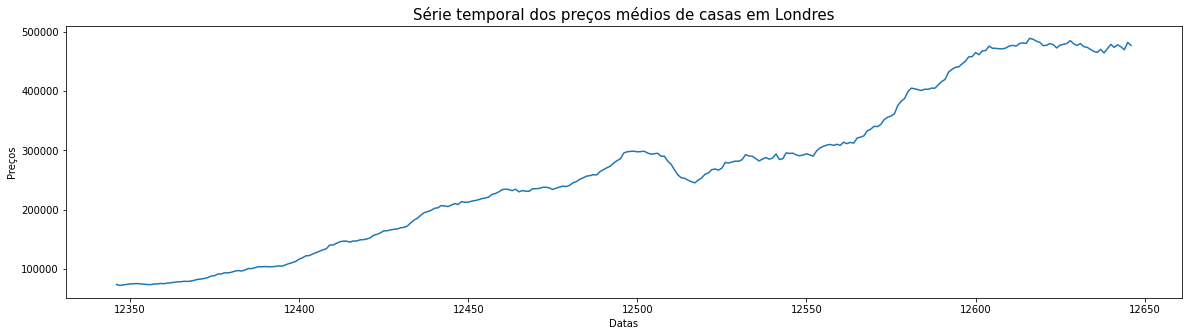

In [7]:
df[df['area']=='london']['average_price'].plot(figsize=(20,5))
plt.xlabel('Datas',size=10)
plt.ylabel('Preços',size=10)
plt.title('Série temporal dos preços médios de casas em Londres', size=15)



Text(0.5, 1.0, 'Distribuição do preço médio das casas em Londres')

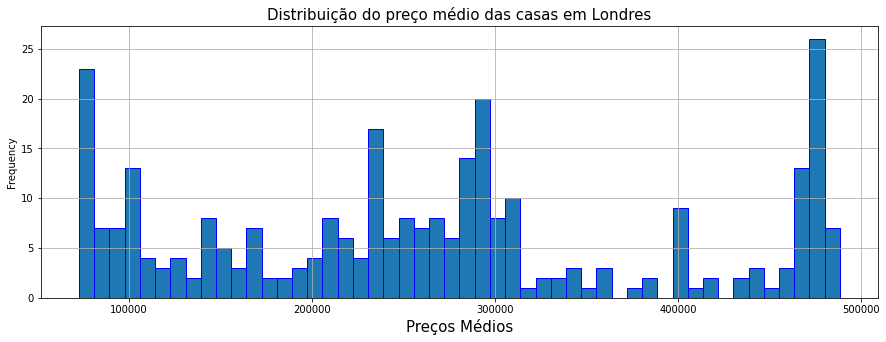

In [8]:
plt.figure(figsize=(15,5))
df2.plot.hist(bins=50,grid=True,edgecolor='b').autoscale(enable=True)
plt.xlabel('Preços Médios',size=15)
plt.title('Distribuição do preço médio das casas em Londres', size=15)


### **Comparando com o preço de demais localidades**

Text(0.5, 1.0, 'Comparando o preço médio das casas em Londres com demais localidades')

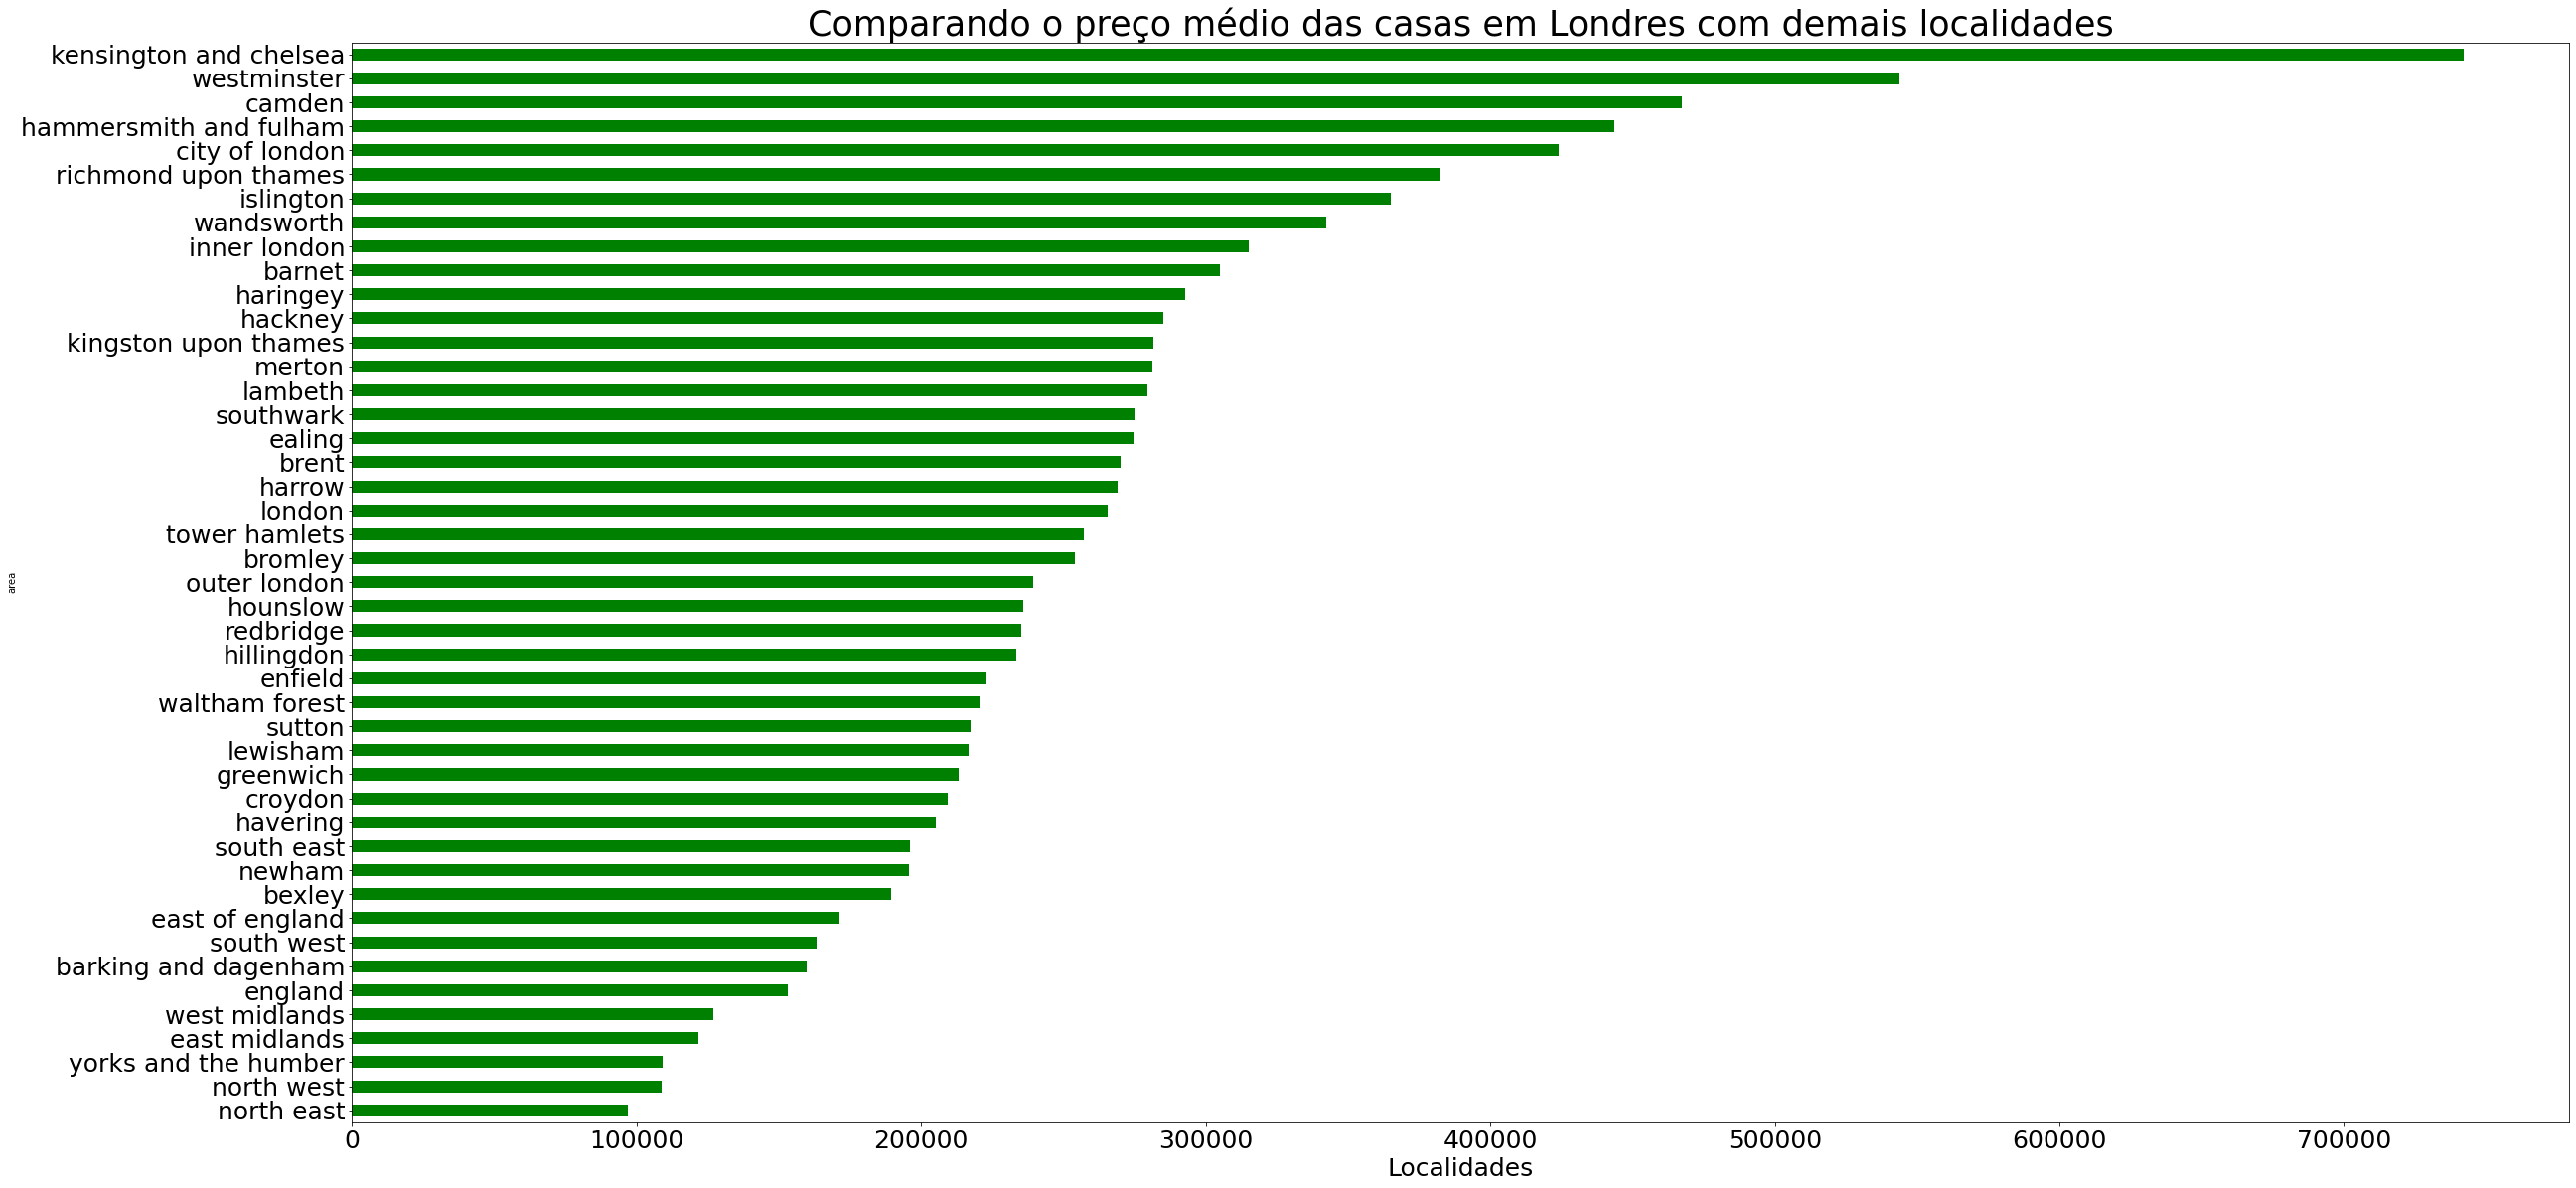

In [9]:
df.groupby('area')['average_price'].mean().sort_values().plot(kind='barh',figsize=(40,20),color='green')
plt.xticks(size=25)
plt.yticks(size=25)
plt.xlabel('Localidades',size=25)
plt.title('Comparando o preço médio das casas em Londres com demais localidades', size=35)


### **Separando Dados Treino e Teste**

Aqui iremos separar as 30 observações finais como dados de teste, ou seja, usaremos esses dados para comparar com as previsões que os algoritmos de suavização exponencial gerarão. As outras 270 observações seão usadas para treinar os algoritmos.

In [10]:
#definindo os dados de treino
df_treino=df2.iloc[:-30]
df_treino

12346     74436
12347     72778
12348     73897
12349     74455
12350     75432
          ...  
12612    475442
12613    479790
12614    480902
12615    480152
12616    488527
Name: average_price, Length: 271, dtype: int64

In [11]:
#definindo os dados de teste
df_teste=df2.iloc[-30:]
df_teste

12617    487085
12618    483833
12619    481762
12620    476290
12621    476848
12622    479772
12623    477860
12624    472357
12625    477253
12626    478485
12627    479931
12628    484724
12629    479550
12630    476545
12631    479775
12632    474551
12633    473454
12634    470067
12635    466500
12636    464818
12637    470092
12638    463976
12639    471053
12640    478348
12641    473390
12642    477727
12643    474318
12644    469422
12645    481710
12646    476588
Name: average_price, dtype: int64

Text(0.5, 0, 'Datas')

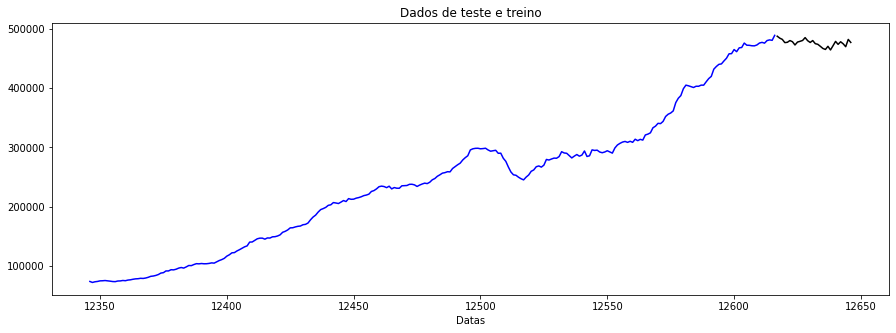

In [12]:
df_treino.plot(figsize=(15,5),color='blue')
df_teste.plot(color='black')
plt.title("Dados de teste e treino")
plt.xlabel('Datas')


### **Algoritmo de Suavização Simples**

A SES(Suavização Exponencial Simples) é uma boa escolha para dados de previsão sem tendência clara ou padrão sazonal. As previsões são calculadas usando médias ponderadas, o que significa que os maiores pesos estão associados às observações mais recentes, enquanto os menores pesos estão associados às observações mais antigas. Esse peso é dado através de α um parâmetro de suavização que varia de 0 a 1. Aqui, executamos duas variantes de suavização exponencial simples:



*   Em fit1, fornecemos explicitamente o modelo com o parâmetro de suavização α = 0,2.
*   Em fit2, nós escolhemos um α = 0,6




In [59]:
# Simple Exponential Smoothing alpha = 0.2
fit1 = SimpleExpSmoothing(df_treino).fit(smoothing_level=0.2,optimized=True)
#gerando as previsões para alpha igual a 0,2
fit1=fit1.forecast(len(df_teste))
fit1


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


271    478447.056703
272    478447.056703
273    478447.056703
274    478447.056703
275    478447.056703
276    478447.056703
277    478447.056703
278    478447.056703
279    478447.056703
280    478447.056703
281    478447.056703
282    478447.056703
283    478447.056703
284    478447.056703
285    478447.056703
286    478447.056703
287    478447.056703
288    478447.056703
289    478447.056703
290    478447.056703
291    478447.056703
292    478447.056703
293    478447.056703
294    478447.056703
295    478447.056703
296    478447.056703
297    478447.056703
298    478447.056703
299    478447.056703
300    478447.056703
dtype: float64

In [60]:
# Simple Exponential Smoothing alpha = 0.6
fit2=SimpleExpSmoothing(df_treino).fit(smoothing_level=0.6,optimized=True)
#gerando as previsões para alpha igual a 0,6
fit2=fit2.forecast(len(df_teste))
fit2

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


271    485116.898637
272    485116.898637
273    485116.898637
274    485116.898637
275    485116.898637
276    485116.898637
277    485116.898637
278    485116.898637
279    485116.898637
280    485116.898637
281    485116.898637
282    485116.898637
283    485116.898637
284    485116.898637
285    485116.898637
286    485116.898637
287    485116.898637
288    485116.898637
289    485116.898637
290    485116.898637
291    485116.898637
292    485116.898637
293    485116.898637
294    485116.898637
295    485116.898637
296    485116.898637
297    485116.898637
298    485116.898637
299    485116.898637
300    485116.898637
dtype: float64

In [61]:
print('Métricas do Algoritmo de Suavização Simple alpha = 0,2')
print('Erro médio absoluto(MAE) do Algoritmo de Suavização Simples :',round(mean_absolute_error(df_teste,fit1),3))
print('Raiz do erro médio quadrado(RMSE) do Algoritmo de Suavização Simples :',round(mean_squared_error(df_teste,fit1)**0.5,3))

Métricas do Algoritmo de Suavização Simple alpha = 0,2
Erro médio absoluto(MAE) do Algoritmo de Suavização Simples : 4654.686
Raiz do erro médio quadrado(RMSE) do Algoritmo de Suavização Simples : 6115.696


In [62]:
print('Métricas do Algoritmo de Suavização Simple alpha = 0,6')
print('Erro médio absoluto(MAE) do Algoritmo de Suavização Simples :',round(mean_absolute_error(df_teste,fit2),3))
print('Raiz do erro médio quadrado(RMSE) do Algoritmo de Suavização Simples :',round(mean_squared_error(df_teste,fit2)**0.5,3))

Métricas do Algoritmo de Suavização Simple alpha = 0,6
Erro médio absoluto(MAE) do Algoritmo de Suavização Simples : 9311.972
Raiz do erro médio quadrado(RMSE) do Algoritmo de Suavização Simples : 10741.669


### **Algoritmo de Suavização Holt**

O método de Holt envolve uma equação de previsão e duas equações de suavização (uma para o nível e outra para a tendência ). Para as previsões de longo prazo, a previsão com o método de Holt aumentará ou diminuirá indefinidamente no futuro. 


In [63]:
#Treinando o modelo
modelo1=Holt(df_treino).fit(smoothing_level=0.7187)
#gerando as previsões
modelo1=modelo1.forecast(len(df_teste))
modelo1

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


271    490026.197155
272    493436.605481
273    496847.013808
274    500257.422135
275    503667.830461
276    507078.238788
277    510488.647114
278    513899.055441
279    517309.463767
280    520719.872094
281    524130.280420
282    527540.688747
283    530951.097073
284    534361.505400
285    537771.913727
286    541182.322053
287    544592.730380
288    548003.138706
289    551413.547033
290    554823.955359
291    558234.363686
292    561644.772012
293    565055.180339
294    568465.588666
295    571875.996992
296    575286.405319
297    578696.813645
298    582107.221972
299    585517.630298
300    588928.038625
dtype: float64

In [64]:
print('Métricas do Algoritmo de Suavização de Holt')
print('Erro médio absoluto(MAE) do Algoritmo de Suavização Holt:',round(mean_absolute_error(df_teste,modelo1),3))
print('Raiz do erro médio quadrado(RMSE) do Algoritmo de Suavização',round(mean_squared_error(df_teste,modelo1)**0.5,3))

Métricas do Algoritmo de Suavização de Holt
Erro médio absoluto(MAE) do Algoritmo de Suavização Holt: 63540.985
Raiz do erro médio quadrado(RMSE) do Algoritmo de Suavização 71423.632


In [65]:
#Treinando o modelo
model2=Holt(df_treino).fit(smoothing_level=0.2)
#gerando as previsões
modelo2=model2.forecast(len(df_teste))
modelo2

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


271    485284.862842
272    486209.835516
273    487134.808190
274    488059.780863
275    488984.753537
276    489909.726211
277    490834.698885
278    491759.671558
279    492684.644232
280    493609.616906
281    494534.589580
282    495459.562254
283    496384.534927
284    497309.507601
285    498234.480275
286    499159.452949
287    500084.425623
288    501009.398296
289    501934.370970
290    502859.343644
291    503784.316318
292    504709.288992
293    505634.261665
294    506559.234339
295    507484.207013
296    508409.179687
297    509334.152361
298    510259.125034
299    511184.097708
300    512109.070382
dtype: float64

In [66]:
print('Métricas do Algoritmo de Suavização de Holt')
print('Erro médio absoluto(MAE) do Algoritmo de Suavização Holt:',round(mean_absolute_error(df_teste,modelo2),3))
print('Raiz do erro médio quadrado(RMSE) do Algoritmo de Suavização',round(mean_squared_error(df_teste,modelo2)**0.5,3))

Métricas do Algoritmo de Suavização de Holt
Erro médio absoluto(MAE) do Algoritmo de Suavização Holt: 22880.842
Raiz do erro médio quadrado(RMSE) do Algoritmo de Suavização 25632.667


### **Algoritmo de Suavização Holt-Winter**

O método de Holt-Winters é adequado para dados com tendências e sazonalidades que incluem um parâmetro de suavização de sazonalidade γ. Existem duas variações para este método:

*   Método aditivo: as variações sazonais são aproximadamente constantes ao longo da série.

*   Método multiplicativo: as variações sazonais estão mudando proporcionalmente ao nível da série.

### **Algoritmo de Suavização Holt-Winter Aditivo**

In [67]:
#treinando o algoritmo de suavização Holt-Winters aditivo
add = ExponentialSmoothing(df_teste, seasonal_periods=4, trend='add', seasonal='add').fit(use_boxcox=True)
#gerando as previsões
add=add.forecast(len(df_teste))
add

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


30    476118.018943
31    475382.582772
32    479183.782137
33    476162.885605
34    476092.347666
35    475356.501109
36    479159.746854
37    476137.239134
38    476066.662184
39    475330.404760
40    479135.699199
41    476111.578487
42    476040.962481
43    475304.293708
44    479111.639158
45    476085.903648
46    476015.248539
47    475278.167936
48    479087.566719
49    476060.214599
50    475989.520343
51    475252.027425
52    479063.481867
53    476034.511324
54    475963.777876
55    475225.872160
56    479039.384590
57    476008.793807
58    475938.021121
59    475199.702122
dtype: float64

In [68]:
print('Métricas do Algoritmo de Suavização de Holt-Winter Aditivo')
print('Erro médio absoluto(MAE) do Algoritmo de Suavização Holt-Winter Aditivo:',round(mean_absolute_error(df_teste,add),3))
print('Raiz do erro médio quadrado(RMSE) do Algoritmo de Suavização Holt-Winter Aditivo:',round(mean_squared_error(df_teste,add)**0.5,3))

Métricas do Algoritmo de Suavização de Holt-Winter Aditivo
Erro médio absoluto(MAE) do Algoritmo de Suavização Holt-Winter Aditivo: 4523.787
Raiz do erro médio quadrado(RMSE) do Algoritmo de Suavização Holt-Winter Aditivo: 5776.415


### **Algoritmo de Suavização Holt-Winter Multiplicativo**

In [69]:
#treinando o algoritmo de suavização Holt-Winters aditivo
mul = ExponentialSmoothing(df_teste, seasonal_periods=4, trend='add', seasonal='mul').fit(use_boxcox=True)
#gerando as previsões
mul=mul.forecast(len(df_teste))
mul

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


30    476839.755639
31    476598.443589
32    479272.424807
33    476926.400178
34    477640.173417
35    477394.694902
36    480069.396430
37    477715.776626
38    478427.066009
39    478177.553529
40    480853.024831
41    478491.997450
42    479200.904070
43    478947.483402
44    481623.770147
45    479255.514280
46    479962.133756
47    479704.924412
48    482382.068770
49    480006.755543
50    480711.178403
51    480450.294047
52    483128.334968
53    480746.128041
54    481448.440067
55    481183.988903
56    483862.962365
57    481474.018388
58    482174.300942
59    481906.386062
dtype: float64

In [70]:
print('Métricas do Algoritmo de Suavização de Holt-Winter Multiplicativo')
print('Erro médio absoluto(MAE) do Algoritmo de Suavização Holt-Winter Multiplicativo:',round(mean_absolute_error(df_teste,mul),3))
print('Raiz do erro médio quadrado(RMSE) do Algoritmo de Suavização Holt-Winter Multiplicativo:',round(mean_squared_error(df_teste,mul)**0.5,3))

Métricas do Algoritmo de Suavização de Holt-Winter Multiplicativo
Erro médio absoluto(MAE) do Algoritmo de Suavização Holt-Winter Multiplicativo: 5898.758
Raiz do erro médio quadrado(RMSE) do Algoritmo de Suavização Holt-Winter Multiplicativo: 7685.602
